In [ ]:
!pip install jax jaxlib flax optax matplotlib

import jax
import jax.numpy as jnp
from jax import random, jit, vmap, grad
import flax.linen as nn
from flax.training import train_state
import optax
import matplotlib.pyplot as plt
from typing import Any, Callable

print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

In [ ]:
class SelfAttention(nn.Module):
    num_heads: int
    dim: int
    @nn.compact
    def __call__(self, x):
        B, L, D = x.shape
        head_dim = D // self.num_heads
        qkv = nn.Dense(3 * D)(x)
        qkv = qkv.reshape(B, L, 3, self.num_heads, head_dim)
        q, k, v = jnp.split(qkv, 3, axis=2)
        q, k, v = q.squeeze(2), k.squeeze(2), v.squeeze(2)
        attn_scores = jnp.einsum('bhqd,bhkd->bhqk', q, k) / jnp.sqrt(head_dim)
        attn_weights = jax.nn.softmax(attn_scores, axis=-1)
        attn_output = jnp.einsum('bhqk,bhvd->bhqd', attn_weights, v)
        attn_output = attn_output.reshape(B, L, D)
        return nn.Dense(D)(attn_output)

class ResidualBlock(nn.Module):
    features: int
    @nn.compact
    def __call__(self, x, training: bool = True):
        residual = x
        x = nn.Conv(self.features, (3, 3), padding='SAME')(x)
        x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.relu(x)
        x = nn.Conv(self.features, (3, 3), padding='SAME')(x)
        x = nn.BatchNorm(use_running_average=not training)(x)
        if residual.shape[-1] != self.features:
            residual = nn.Conv(self.features, (1, 1))(residual)
        return nn.relu(x + residual)

class AdvancedCNN(nn.Module):
    num_classes: int = 10
    @nn.compact
    def __call__(self, x, training: bool = True):
        x = nn.Conv(32, (3, 3), padding='SAME')(x)
        x = nn.relu(x)
        x = ResidualBlock(64)(x, training)
        x = ResidualBlock(64)(x, training)
        x = nn.max_pool(x, (2, 2), strides=(2, 2))
        x = ResidualBlock(128)(x, training)
        x = ResidualBlock(128)(x, training)
        x = jnp.mean(x, axis=(1, 2))
        x = x[:, None, :]
        x = SelfAttention(num_heads=4, dim=128)(x)
        x = x.squeeze(1)
        x = nn.Dense(256)(x)
        x = nn.relu(x)
        x = nn.Dropout(0.5, deterministic=not training)(x)
        x = nn.Dense(self.num_classes)(x)
        return x

In [ ]:
class TrainState(train_state.TrainState):
    batch_stats: Any

def create_learning_rate_schedule(base_lr: float = 1e-3, warmup_steps: int = 100, decay_steps: int = 1000) -> optax.Schedule:
    warmup_fn = optax.linear_schedule(init_value=0.0, end_value=base_lr, transition_steps=warmup_steps)
    decay_fn = optax.cosine_decay_schedule(init_value=base_lr, decay_steps=decay_steps, alpha=0.1)
    return optax.join_schedules(schedules=[warmup_fn, decay_fn], boundaries=[warmup_steps])

def create_optimizer(learning_rate_schedule: optax.Schedule) -> optax.GradientTransformation:
    return optax.chain(optax.clip_by_global_norm(1.0), optax.adamw(learning_rate=learning_rate_schedule, weight_decay=1e-4))

In [ ]:
@jit
def compute_metrics(logits, labels):
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return {'loss': loss, 'accuracy': accuracy}

def create_train_state(rng, model, input_shape, learning_rate_schedule):
    variables = model.init(rng, jnp.ones(input_shape), training=False)
    params = variables['params']
    batch_stats = variables.get('batch_stats', {})
    tx = create_optimizer(learning_rate_schedule)
    return TrainState.create(apply_fn=model.apply, params=params, tx=tx, batch_stats=batch_stats)

@jit
def train_step(state, batch, dropout_rng):
    images, labels = batch
    def loss_fn(params):
        variables = {'params': params, 'batch_stats': state.batch_stats}
        logits, new_model_state = state.apply_fn(variables, images, training=True, mutable=['batch_stats'], rngs={'dropout': dropout_rng})
        loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
        return loss, (logits, new_model_state)
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (logits, new_model_state)), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads, batch_stats=new_model_state['batch_stats'])
    metrics = compute_metrics(logits, labels)
    return state, metrics

@jit
def eval_step(state, batch):
    images, labels = batch
    variables = {'params': state.params, 'batch_stats': state.batch_stats}
    logits = state.apply_fn(variables, images, training=False)
    return compute_metrics(logits, labels)

In [ ]:
def generate_synthetic_data(rng, num_samples=1000, img_size=32):
    rng_x, rng_y = random.split(rng)
    images = random.normal(rng_x, (num_samples, img_size, img_size, 3))
    labels = random.randint(rng_y, (num_samples,), 0, 10)
    return images, labels

def create_batches(images, labels, batch_size=32):
    num_batches = len(images) // batch_size
    for i in range(num_batches):
        idx = slice(i * batch_size, (i + 1) * batch_size)
        yield images[idx], labels[idx]

JAX version: 0.7.2
Devices: [CpuDevice(id=0)]
Starting training...
Epoch 1/5: Loss: 2.7567, Train Acc: 0.1270, Test Acc: 0.0938
Epoch 2/5: Loss: 2.3667, Train Acc: 0.1190, Test Acc: 0.0938
Epoch 3/5: Loss: 2.2344, Train Acc: 0.1946, Test Acc: 0.0938
Epoch 4/5: Loss: 1.9406, Train Acc: 0.3115, Test Acc: 0.0938
Epoch 5/5: Loss: 1.4353, Train Acc: 0.4960, Test Acc: 0.1198


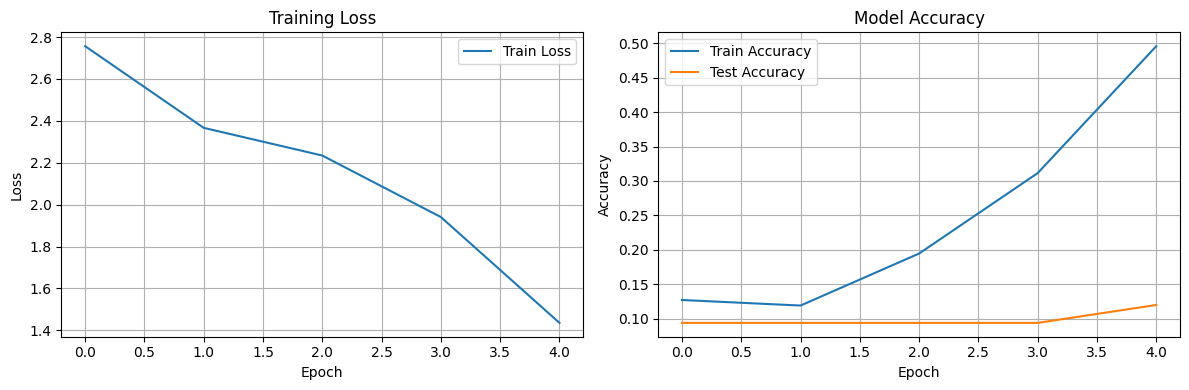


✅ Tutorial complete! This covers:
- Custom Flax modules (ResNet blocks, Self-Attention)
- Advanced Optax optimizers (AdamW with gradient clipping)
- Learning rate schedules (warmup + cosine decay)
- JAX transformations (@jit for performance)
- Proper state management (batch normalization statistics)
- Complete training pipeline with evaluation


In [4]:
def train_model(num_epochs=5, batch_size=32):
    rng = random.PRNGKey(0)
    rng, data_rng, model_rng = random.split(rng, 3)
    train_images, train_labels = generate_synthetic_data(data_rng, num_samples=1000)
    test_images, test_labels = generate_synthetic_data(data_rng, num_samples=200)
    model = AdvancedCNN(num_classes=10)
    lr_schedule = create_learning_rate_schedule(base_lr=1e-3, warmup_steps=50, decay_steps=500)
    state = create_train_state(model_rng, model, (1, 32, 32, 3), lr_schedule)
    history = {'train_loss': [], 'train_acc': [], 'test_acc': []}
    print("Starting training...")
    for epoch in range(num_epochs):
        train_metrics = []
        for batch in create_batches(train_images, train_labels, batch_size):
            rng, dropout_rng = random.split(rng)
            state, metrics = train_step(state, batch, dropout_rng)
            train_metrics.append(metrics)
        train_loss = jnp.mean(jnp.array([m['loss'] for m in train_metrics]))
        train_acc = jnp.mean(jnp.array([m['accuracy'] for m in train_metrics]))
        test_metrics = [eval_step(state, batch) for batch in create_batches(test_images, test_labels, batch_size)]
        test_acc = jnp.mean(jnp.array([m['accuracy'] for m in test_metrics]))
        history['train_loss'].append(float(train_loss))
        history['train_acc'].append(float(train_acc))
        history['test_acc'].append(float(test_acc))
        print(f"Epoch {epoch + 1}/{num_epochs}: Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
    return history, state

history, trained_state = train_model(num_epochs=5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.set_title('Training Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history['train_acc'], label='Train Accuracy')
ax2.plot(history['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy'); ax2.set_title('Model Accuracy'); ax2.legend(); ax2.grid(True)
plt.tight_layout(); plt.show()

print("\n✅ Tutorial complete! This covers:")
print("- Custom Flax modules (ResNet blocks, Self-Attention)")
print("- Advanced Optax optimizers (AdamW with gradient clipping)")
print("- Learning rate schedules (warmup + cosine decay)")
print("- JAX transformations (@jit for performance)")
print("- Proper state management (batch normalization statistics)")
print("- Complete training pipeline with evaluation")